In [35]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from model import Net1
import os

In [36]:
modelpath = './model'
os.makedirs(modelpath,exist_ok=True)

In [37]:
# shape (# samples per rep, # reps, # channels (if EMI))

train_EMI = np.load('../../data/12_2023/Train_data_grads_off/EMI_coils_data.npy')
train_RX = np.load('../../data/12_2023/Train_data_grads_off/RX_coils_data.npy')

test_EMI = np.load('../../data/12_2023/Test_data_grads_off/EMI_coils_data.npy')
test_RX = np.load('../../data/12_2023/Test_data_grads_off/RX_coils_data.npy')


In [38]:
train_EMI = np.transpose(train_EMI, (1,2,0))
test_EMI = np.transpose(test_EMI, (1,2,0))

In [39]:
print(train_EMI.shape)
print(train_RX.shape)
print(test_EMI.shape)
print(test_RX.shape)

(10000, 1, 1251)
(10000, 1251)
(3000, 1, 1251)
(3000, 1251)


In [40]:
train_emi, val_emi, train_rx, val_rx = train_test_split(train_EMI,train_RX,shuffle=True,test_size=0.2)

print(train_emi.shape,train_rx.shape,val_emi.shape,val_rx.shape)

(8000, 1, 1251) (8000, 1251) (2000, 1, 1251) (2000, 1251)


In [41]:
type(train_emi)

numpy.ndarray

In [42]:
train_emi = torch.tensor(train_emi,dtype=torch.float)
train_rx = torch.tensor(train_rx,dtype=torch.float)
val_emi = torch.tensor(val_emi,dtype=torch.float)
val_rx = torch.tensor(val_rx,dtype=torch.float)

test_emi = torch.tensor(test_EMI,dtype=torch.float)
test_rx = torch.tensor(test_RX,dtype=torch.float)

print(train_emi.shape,train_rx.shape,val_emi.shape,val_rx.shape)

torch.Size([8000, 1, 1251]) torch.Size([8000, 1251]) torch.Size([2000, 1, 1251]) torch.Size([2000, 1251])


In [43]:
device = (
    "cuda" if torch.cuda.is_available()
    else "cpu"
)
device

'cpu'

In [44]:
batch_size = 64
epochs = 1
lr = 0.001
num_workers = 8

In [45]:
train_ds = TensorDataset(train_emi,train_rx)
val_ds = TensorDataset(val_emi,val_rx)

train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=num_workers)
val_dl = DataLoader(val_ds,batch_size=batch_size,shuffle=True,num_workers=num_workers)

In [46]:
model = Net1().to(device)
optimizer = optim.Adam(model.parameters(),lr=lr)
loss_fn = nn.MSELoss()

In [47]:
def train(dataloader,model,loss_fn):
    model.train()
    train_loss = 0
    num_batches = len(dataloader)
    for i, (emi,rx) in enumerate(train_dl):
        inputs = emi.to(device)
        labels = torch.unsqueeze(rx,1).to(device)

        outs = model(inputs)
        print(labels.shape,outs.shape)
        loss = loss_fn(outs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return round(train_loss/num_batches,10)

In [48]:
def eval(dataloader,model,loss_fn):
    model.eval()
    eval_loss = 0
    num_batches = len(dataloader)
    with torch.no_grad():
        for i, (emi,rx) in enumerate(dataloader):
            inputs = emi.to(device)
            labels = torch.unsqueeze(rx,1).to(device)

            outs = model(inputs)

            loss = loss_fn(outs,labels)
            eval_loss += loss.item()
    return round(eval_loss/num_batches,10)

In [49]:
'''
train_loss = []
eval_loss = []

for e in range(epochs):
    tloss = train(train_dl,model,loss_fn)
    train_loss.append(tloss)

    vloss = eval(val_dl,model,loss_fn)
    eval_loss.append(vloss)

    print(f'Epoch: {e}, Train Loss: {tloss}, Val Loss: {vloss}')

    if e+1 == epochs:
        torch.save(model,os.path.join(modelpath,f'epoch-{e+1}.pth'))
'''

"\ntrain_loss = []\neval_loss = []\n\nfor e in range(epochs):\n    tloss = train(train_dl,model,loss_fn)\n    train_loss.append(tloss)\n\n    vloss = eval(val_dl,model,loss_fn)\n    eval_loss.append(vloss)\n\n    print(f'Epoch: {e}, Train Loss: {tloss}, Val Loss: {vloss}')\n\n    if e+1 == epochs:\n        torch.save(model,os.path.join(modelpath,f'epoch-{e+1}.pth'))\n"

In [50]:
test_EMI.shape

(3000, 1, 1251)

In [51]:
pred = model(test_emi[:10])

In [52]:
test = test_emi[:10]
gt = test_rx[:10]

In [53]:
test.shape

torch.Size([10, 1, 1251])

In [54]:
gt.shape

torch.Size([10, 1251])

In [56]:
model = Net1()
model = torch.load('./model/epoch-20.pth')
model.eval()
pred = model(test)

In [59]:
pred.shape

torch.Size([10, 1, 1251])

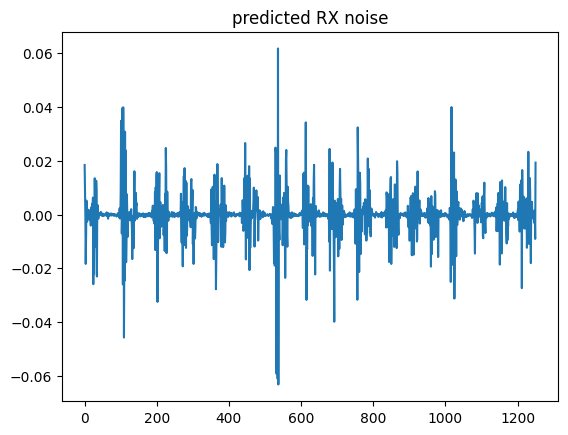

In [72]:
plt.plot(pred.detach().numpy()[6,0])
plt.title('predicted RX noise');

In [62]:
gt.shape

torch.Size([10, 1251])

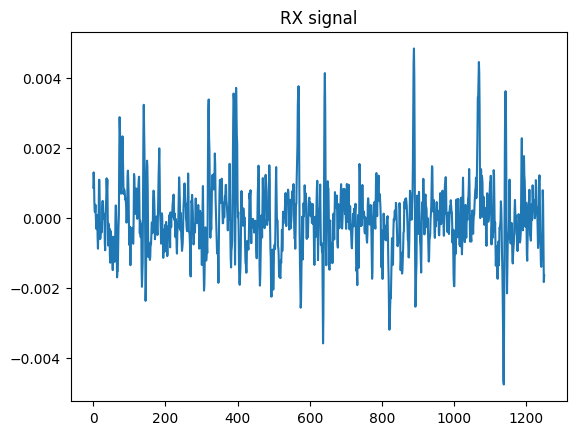

In [71]:
plt.plot(train_rx.detach().numpy()[6])
plt.title('RX signal');

In [73]:
corr = gt.detach().numpy()[6] - pred.detach().numpy()[6,0]

Text(0.5, 1.0, 'RX - pred noise')

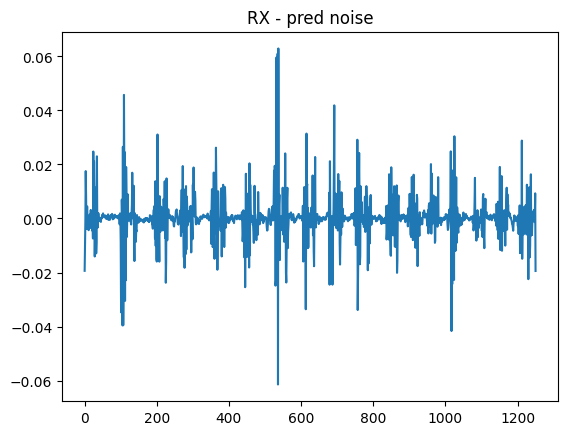

In [74]:
plt.plot(corr)
plt.title('RX - pred noise')